<a href="https://colab.research.google.com/github/adekoerniawan/data_analysis/blob/main/DS_AdeKurniawan_Lev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Script Author :** Ade Kurniawan

**Date :** July 20, 2026

**Objectives :** To build and evaluate a simple linear regression model for predicting house prices based on area and carport ownership, and to apply this model to estimate prices for new house data.

**Model :** (Ordinary Least Squares - OLS)

In [92]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
# --- Define Conversion Functions ---
def convert_idr_billion_to_float(price_str):
    if pd.isna(price_str):
        return np.nan
    s = str(price_str).replace('IDR ', '').replace(' Billion', '').strip()
    try:
        return float(s) * 1_000_000_000
    except ValueError:
        return np.nan

def convert_to_meters(value, unit):
    if pd.isna(value) or pd.isna(unit):
        return np.nan
    value = pd.to_numeric(value, errors='coerce')
    if pd.isna(value):
        return np.nan
    unit = str(unit).lower().strip()
    if unit == 'meter':
        return value
    elif unit == 'centimeter':
        return value / 100
    else:
        return np.nan

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.nan
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape

In [94]:
# --- 1. LOAD DATA ---
try:
    train_df = pd.read_excel('data_train.xlsx')
    eval_df = pd.read_excel('data_evaluation.xlsx')
except FileNotFoundError as e:
    print(f"ERROR: {e}. Pastikan file Excel berada di direktori yang sama dengan skrip ini.")
    print("Skrip dihentikan karena file tidak ditemukan.")
    exit()

In [95]:
# --- 2. CLEAN COLUMN NAMES ---
train_df.columns = train_df.columns.str.strip().str.lower()
eval_df.columns = eval_df.columns.str.strip().str.lower()

In [96]:
# --- 3. INITIAL DATA DIAGNOSIS AFTER LOADING ---
print("\n--- DIAGNOSIS: Data Train Setelah Dimuat (Kolom Bersih) ---")
print(train_df.head())
print(train_df.info())
print("\n--- DIAGNOSIS: Data Evaluation Setelah Dimuat (Kolom Bersih) ---")
print(eval_df.head())
print(eval_df.info())
print("\nNilai Unik dan Jumlah houseid di Data Evaluasi yang Dimuat (Setelah Kolom Bersih):")
print(eval_df['houseid'].value_counts(dropna=False))


--- DIAGNOSIS: Data Train Setelah Dimuat (Kolom Bersih) ---
   houseid  length lengthunit  width widthunit  iscarport            price  \
0      NaN     NaN        NaN    NaN       NaN        NaN              NaN   
1      1.0    20.0     meter    10.0    meter         1.0   IDR 5 Billion    
2      NaN     NaN        NaN    NaN       NaN        NaN              NaN   
3      2.0    40.0     meter    20.0    meter         0.0  IDR 18 Billion    
4      NaN     NaN        NaN    NaN       NaN        NaN              NaN   

            notes  
0             NaN  
1  TRAINING DATA   
2             NaN  
3  TRAINING DATA   
4             NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseid     7 non-null      float64
 1   length      7 non-null      float64
 2   lengthunit  7 non-null      object 
 3   width       7 non-null      float64
 4

In [97]:
# --- 4. REMOVE EMPTY ROWS ---
train_df.dropna(how='all', inplace=True)
eval_df.dropna(how='all', inplace=True)

In [98]:
# --- 5. DATA DIAGNOSIS AFTER EMPTY ROWS REMOVED ---
print("\n--- DIAGNOSIS: Data Train Setelah Baris Kosong Dihapus ---")
print(train_df.head())
print(train_df.info())
print("\n--- DIAGNOSIS: Data Evaluation Setelah Baris Kosong Dihapus ---")
print(eval_df.head())
print(eval_df.info())
print("\nNilai Unik dan Jumlah houseid di Data Evaluasi Setelah Baris Kosong Dihapus:")
print(eval_df['houseid'].value_counts(dropna=False))


--- DIAGNOSIS: Data Train Setelah Baris Kosong Dihapus ---
   houseid  length   lengthunit   width    widthunit  iscarport  \
1      1.0    20.0       meter     10.0       meter         1.0   
3      2.0    40.0       meter     20.0       meter         0.0   
5      3.0  3000.0  centimeter   2000.0  centimeter         1.0   
7      4.0  1000.0  centimeter   3000.0  centimeter         0.0   
9      5.0    20.0       meter     50.0       meter         1.0   

             price           notes  
1   IDR 5 Billion   TRAINING DATA   
3  IDR 18 Billion   TRAINING DATA   
5  IDR 13 Billion   TRAINING DATA   
7   IDR 6 Billion   TRAINING DATA   
9  IDR 21 Billion   TRAINING DATA   
<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 1 to 13
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseid     7 non-null      float64
 1   length      7 non-null      float64
 2   lengthunit  7 non-null      object 
 3   width    

In [99]:
# --- 6. FEATURE ENGINEERING & PREPROCESSING ---
train_df['price_numeric'] = train_df['price'].apply(convert_idr_billion_to_float)
train_df['length_m'] = train_df.apply(lambda row: convert_to_meters(row['length'], row['lengthunit']), axis=1)
train_df['width_m'] = train_df.apply(lambda row: convert_to_meters(row['width'], row['widthunit']), axis=1)
eval_df['length_m'] = eval_df.apply(lambda row: convert_to_meters(row['length'], row['lengthunit']), axis=1)
eval_df['width_m'] = eval_df.apply(lambda row: convert_to_meters(row['width'], row['widthunit']), axis=1)
train_df['area'] = train_df['length_m'] * train_df['width_m']
eval_df['area'] = eval_df['length_m'] * eval_df['width_m']
train_df['iscarport'] = pd.to_numeric(train_df['iscarport'], errors='coerce')
eval_df['iscarport'] = pd.to_numeric(eval_df['iscarport'], errors='coerce')


             MEMULAI EXPLORATORY DATA ANALYSIS (EDA)

--- 7.1. Ringkasan Statistik Deskriptif Data Pelatihan ---
        houseid       length        width  iscarport  price_numeric  \
count  7.000000     7.000000     7.000000   7.000000   7.000000e+00   
mean   4.000000   592.857143   730.000000   0.571429   1.171429e+10   
std    2.160247  1121.378828  1243.194809   0.534522   6.047432e+09   
min    1.000000    20.000000    10.000000   0.000000   5.000000e+09   
25%    2.500000    20.000000    15.000000   0.000000   7.000000e+09   
50%    4.000000    40.000000    20.000000   1.000000   1.100000e+10   
75%    5.500000   525.000000  1025.000000   1.000000   1.550000e+10   
max    7.000000  3000.000000  3000.000000   1.000000   2.100000e+10   

        length_m    width_m         area  
count   7.000000   7.000000     7.000000  
mean   27.142857  22.857143   542.857143  
std    13.801311  13.801311   281.999662  
min    10.000000  10.000000   200.000000  
25%    20.000000  15.000000   3

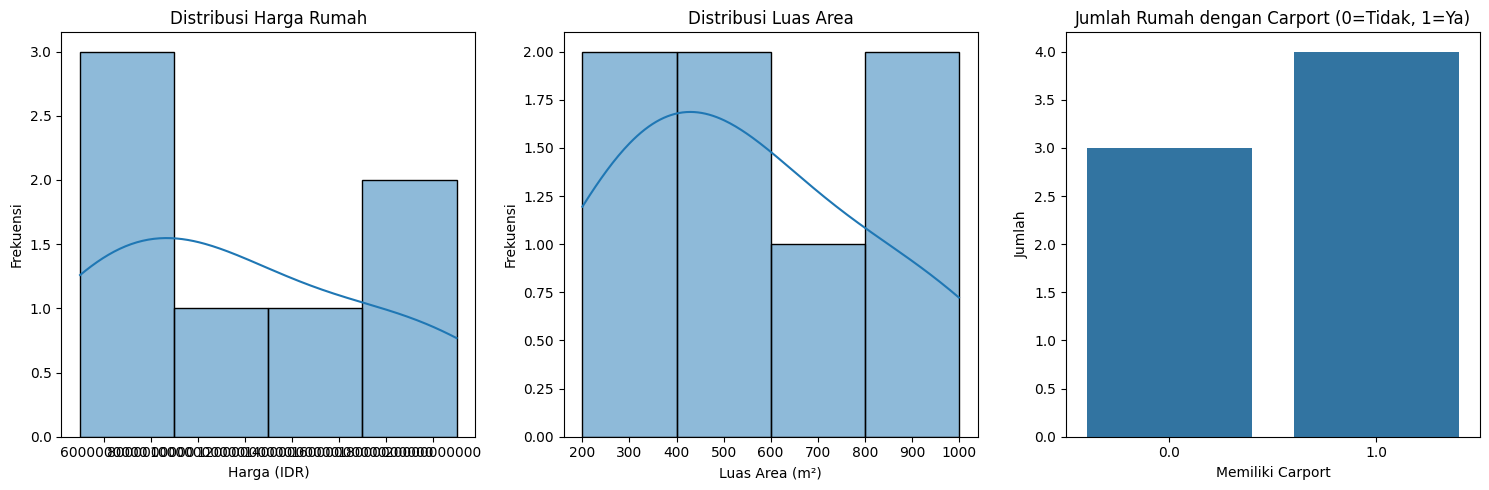


--- 7.4. Hubungan antara Luas Area dan Harga ---


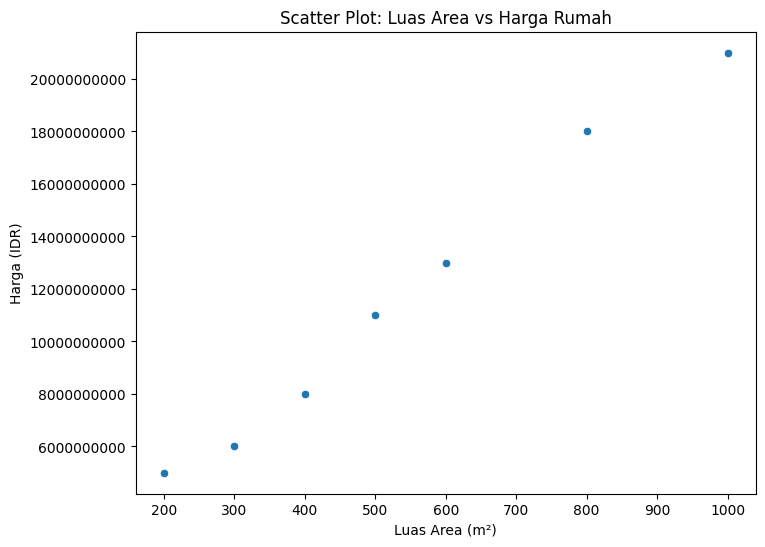


--- 7.5. Hubungan antara Carport dan Harga ---


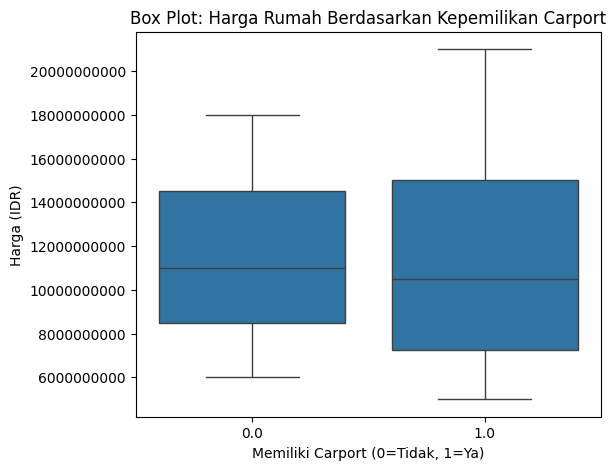


--- EDA Selesai ---


In [100]:
# --- 7. EXPLORATORY DATA ANALYSIS (EDA) ---
print("\n" + "="*50)
print("             MEMULAI EXPLORATORY DATA ANALYSIS (EDA)")
print("="*50)

print("\n--- 7.1. Ringkasan Statistik Deskriptif Data Pelatihan ---")
print(train_df.describe())

print("\n--- 7.2. Tipe Data dan Jumlah Non-Null Setelah Preprocessing ---")
print(train_df.info())

print("\n--- 7.3. Distribusi Variabel Kunci (Visualisasi) ---")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_df['price_numeric'].dropna(), kde=True)
plt.title('Distribusi Harga Rumah')
plt.xlabel('Harga (IDR)')
plt.ylabel('Frekuensi')
plt.ticklabel_format(style='plain', axis='x')

plt.subplot(1, 3, 2)
sns.histplot(train_df['area'].dropna(), kde=True)
plt.title('Distribusi Luas Area')
plt.xlabel('Luas Area (m²)')
plt.ylabel('Frekuensi')

plt.subplot(1, 3, 3)
sns.countplot(x=train_df['iscarport'].dropna())
plt.title('Jumlah Rumah dengan Carport (0=Tidak, 1=Ya)')
plt.xlabel('Memiliki Carport')
plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

print("\n--- 7.4. Hubungan antara Luas Area dan Harga ---")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area', y='price_numeric', data=train_df)
plt.title('Scatter Plot: Luas Area vs Harga Rumah')
plt.xlabel('Luas Area (m²)')
plt.ylabel('Harga (IDR)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print("\n--- 7.5. Hubungan antara Carport dan Harga ---")
plt.figure(figsize=(6, 5))
sns.boxplot(x='iscarport', y='price_numeric', data=train_df)
plt.title('Box Plot: Harga Rumah Berdasarkan Kepemilikan Carport')
plt.xlabel('Memiliki Carport (0=Tidak, 1=Ya)')
plt.ylabel('Harga (IDR)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print("\n--- EDA Selesai ---")
print("="*50)

In [101]:
# --- 8. DATA PREPARATION FOR MODEL ---
y_train = train_df['price_numeric']
X_train = train_df[['area', 'iscarport']]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
X_train = sm.add_constant(X_train)

In [102]:
# --- 9. TRAIN MANUAL OLS MODEL ---
X_train_np = X_train.values
y_train_np = y_train.values.reshape(-1, 1)

try:
    beta_hat = np.linalg.inv(X_train_np.T @ X_train_np) @ X_train_np.T @ y_train_np
    print("\nModel berhasil dilatih.")
except np.linalg.LinAlgError:
    print("\nERROR: Matriks singular. Tidak dapat menghitung invers.")
    print("Ini sering terjadi jika fitur sangat berkorelasi, ada kolom yang semuanya nol setelah NaN diisi, atau jumlah sampel terlalu sedikit.")
    beta_hat = np.zeros((X_train_np.shape[1], 1))
    print("Koefisien model diatur ke nol sebagai fallback.")

y_train_pred = X_train_np @ beta_hat


Model berhasil dilatih.


In [103]:
# --- 10. EVALUATE MODEL ON TRAINING DATA ---
rmse_train = np.sqrt(np.mean((y_train_np - y_train_pred) ** 2))
print(f"RMSE pada data pelatihan: {rmse_train:.2f}")

mape_train = mean_absolute_percentage_error(y_train_np, y_train_pred)
print(f"MAPE pada data pelatihan: {mape_train:.2f}%")

if not pd.isna(mape_train):
    general_accuracy_score = 100 - mape_train
    print(f"Skor Akurasi Umum pada data pelatihan: {general_accuracy_score:.2f}%")
else:
    print("Tidak dapat menghitung Skor Akurasi Umum karena MAPE tidak valid.")

RMSE pada data pelatihan: 515978455.20
MAPE pada data pelatihan: 5.69%
Skor Akurasi Umum pada data pelatihan: 94.31%


In [104]:
# --- 11. PREDICT ON EVALUATION DATA ---
X_eval = eval_df[['area', 'iscarport']]
X_eval = X_eval.fillna(0)
X_eval = sm.add_constant(X_eval)

y_eval_pred = X_eval.values @ beta_hat
eval_df['predicted_price'] = y_eval_pred

In [105]:
# --- 12. OUTPUT PREDICTION RESULTS ---
print("\n--- Hasil Prediksi pada Data Evaluasi ---")
print(eval_df[['houseid', 'predicted_price']])


--- Hasil Prediksi pada Data Evaluasi ---
   houseid  predicted_price
1      8.0     2.163636e+10
3      9.0     1.281818e+10
5     10.0     4.545455e+09
